In [259]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import openpyxl
import torch
import torch.nn as nn
import torch.optim as optim

from shapely.geometry import box
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [297]:
train_file_path = '/content/drive/MyDrive/Progettino/Excel/Training_Data.xlsx'
predict_file_path = '/content/drive/MyDrive/Progettino/Excel/Testing_Data.xlsx'
Electoral_college_path = '/content/drive/MyDrive/Progettino/Excel/Electoral_Colleges.xlsx'
shape_path ='/content/drive/MyDrive/Progettino/Shapefile/cb_2018_us_state_500k.shp'

In [298]:
train_excel_data = pd.ExcelFile(train_file_path)
predict_excel_data = pd.ExcelFile(predict_file_path)
shape = gpd.read_file(shape_path)
shape1 = gpd.read_file(shape_path)

In [262]:
class ProbitRegression(nn.Module):
    def __init__(self, input_dim):
        super(ProbitRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return torch.distributions.Normal(0, 1).cdf(self.linear(x))

In [290]:
y_pred = []

for sheet_name in train_excel_data.sheet_names:
    train_data = pd.read_excel(train_file_path, sheet_name=sheet_name)

    X = train_data[['GDP_G', 'Inflation', 'House_price', 'Election_Results', 'College_Graduates', 'Personal_Income']].values
    X = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)
    y = train_data['United_States'].values

    scaler = StandardScaler()
    X[:, 1:] = scaler.fit_transform(X[:, 1:])

    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    model = ProbitRegression(X.shape[1])
    criterion = nn.BCELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    num_epochs = 5

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()

    predict_excel_data = pd.read_excel(predict_file_path, sheet_name=sheet_name)

    X_new = predict_excel_data[['GDP_G', 'Inflation', 'House_price', 'Election_Results', 'College_Graduates', 'Personal_Income']].values
    X_new = np.concatenate([np.ones((X_new.shape[0], 1)), X_new], axis=1)

    X_new[:, 1:] = scaler.transform(X_new[:, 1:])

    X_new = torch.tensor(X_new, dtype=torch.float32)

    model.eval()
    with torch.no_grad():
        predictions = model(X_new).numpy().flatten().tolist()
        y_pred.extend(predictions)

In [274]:
coefficients = model.linear.weight.data.numpy().flatten()

In [275]:
coefficients

array([-0.2535633 ,  0.14469714,  0.02754753,  0.03300547,  0.13774917,
        0.16855185, -0.26189038], dtype=float32)

In [266]:
keys_c = ['B_0', 'B_1', 'B_2', 'B_3', 'B_4', 'B_5','B_6']
coefficients = dict(zip(keys_c, coefficients))


In [238]:
coefficients

{'B_0': -0.22378196,
 'B_1': 0.7286147,
 'B_2': 0.17752339,
 'B_3': 0.49511087,
 'B_4': 0.57314646,
 'B_5': 0.01311908,
 'B_6': -0.2035167}

In [291]:
keys = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia',
    'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

state_values = dict(zip(keys, y_pred))
df = pd.DataFrame(list(state_values.items()), columns=['State', 'Probability'])

In [301]:
shape = pd.merge(left=shape, right=df, left_on='NAME', right_on='State', how='left')
shape = shape.dropna()
shape = shape[~shape['NAME'].isin(['Alaska', 'Hawaii', 'Puerto Rico'])]

shape1 = pd.merge( left=shape1, right=df, left_on='NAME', right_on='State', how='left')
shape1 = shape1.dropna()

In [302]:
alaska = shape1[shape1['NAME'] == 'Alaska'].copy()
hawaii = shape1[shape1['NAME'] == 'Hawaii'].copy()

alaska_geom = box(-179.148909, 51.214183, -129.979493, 71.365162)
hawaii_geom = box(-178.334698, 18.910361, -154.806773, 28.402123)

binary_cmap = ListedColormap(['blue', 'red'])

In [300]:
Electoral_college = pd.read_excel(Electoral_college_path)
Electoral_college.columns = ['State', 'Electoral_College']
Electoral_college_r = pd.merge( left=Electoral_college, right=df, left_on='State', right_on='State', how='left')

In [303]:
Democrat = 0
Republican = 0
for index, row in Electoral_college_r.iterrows():
    if row['Probability'] > 0.5:
        Republican += row['Electoral_College']
    else:
        Democrat += row['Electoral_College']

print('Democrat:', Democrat)
print('Republican:', Republican)
print(' ')
if Democrat > Republican:
    print(f'Democrat wins')
else:
    print(f'Republican wins')

Democrat: 328
Republican: 210
 
Democrat wins


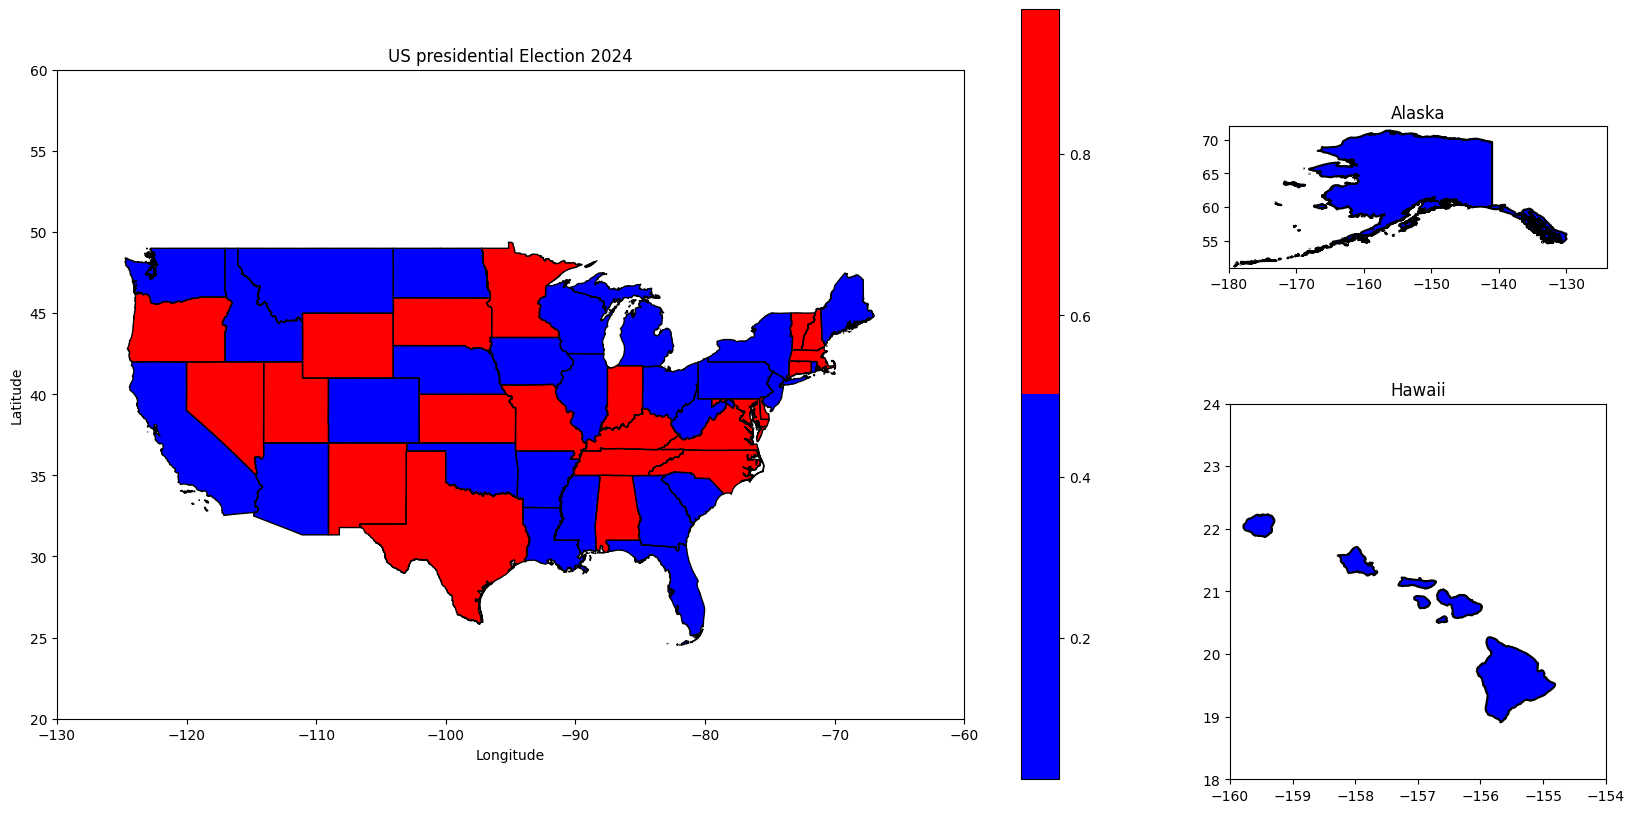

In [304]:
fig = plt.figure(figsize=(20, 10))
gs = GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.05)

# Main map
ax_main = fig.add_subplot(gs[:, 0])
shape.boundary.plot(ax=ax_main, linewidth=1, edgecolor='black')
shape.plot(ax=ax_main, column='Probability', legend=True, cmap=binary_cmap)
ax_main.set_xlim(-130, -60)
ax_main.set_ylim(20, 60)
ax_main.set_title('US presidential Election 2024')
ax_main.set_xlabel('Longitude')
ax_main.set_ylabel('Latitude')

# Alaska map
ax_alaska = fig.add_subplot(gs[0, 1])
alaska.boundary.plot(ax=ax_alaska, color='black')
alaska.plot(ax=ax_alaska, column='Probability', cmap=binary_cmap)
ax_alaska.set_title('Alaska')
ax_alaska.set_aspect('equal')
ax_alaska.set_xlim(-180, -124)
ax_alaska.set_ylim(51, 72)

# Hawaii map
ax_hawaii = fig.add_subplot(gs[1, 1])
hawaii.boundary.plot(ax=ax_hawaii, color='black')
hawaii.plot(ax=ax_hawaii, column='Probability', cmap=binary_cmap)
ax_hawaii.set_title('Hawaii')
ax_hawaii.set_aspect('equal')
ax_hawaii.set_xlim(-160, -154)
ax_hawaii.set_ylim(18, 24)

plt.show()


In [307]:
from google.colab import files

In [308]:
fig.savefig('map.jpg', dpi=300)
files.download('map.jpg')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>